<a href="https://colab.research.google.com/github/AbdullahHassan176/FinGanFlow/blob/main/Implementation_of_GAN_for_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of GAN for beginners.

**generative adversarial networks (GANs)** are able to learn how to reproduce synthetic data that looks real. GANs is ***the most interesting idea in the last 10 years in ML,*** by Yann LeCun, one of the fathers of deep learning.
In this notebook, we will going to train a GAN to reproduce our dataset.
To facilitate understanding, i chose to do simple with the dataset. So i choose to create a dataset by generating random numbers following normal law. Thus, we can change the parameter(`maen` and `stddev`) of this low to observe the impact on the GAN learning and for more fun.
GAN is not only for image data. We will going to train GAN on simple numerical one dimension data.

For more understanding of GAN concept, please visit this notebook https://www.kaggle.com/roblexnana/understanding-generative-models-gan

### Table of interest:
1. Create our dataset.
2. Define our generator and our disciminator.
3. Define our losses functions.
4. Define the optimizers and the train operations.
5. Training and visualization of results.

Let's get started.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model

import matplotlib.pyplot as plt


## 1. Create our dataset.

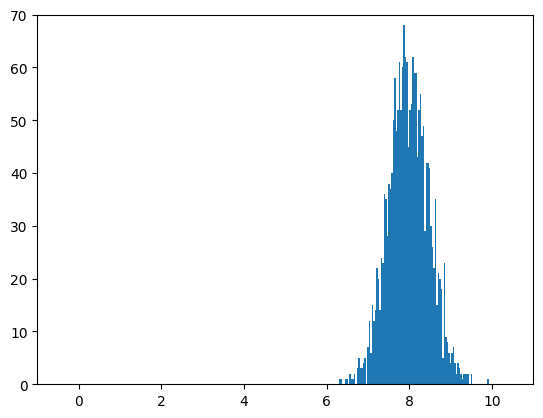

In [2]:
# fonction to generate our dataset
def sample_dataset():
    dataset_shape = (2000, 1)
    return tf.random.normal(mean=8., shape=dataset_shape, stddev=0.5, dtype=tf.float32)

# visualize our data with histogram
plt.hist(sample_dataset().numpy(), 100)
axes = plt.gca()
axes.set_xlim([-1,11])
axes.set_ylim([0, 70])
plt.show()


## 2. Define our generator and our disciminator.

In [3]:
def generator(input_shape):
    """Defines the generator keras.Model.
    Args:
        input_shape: the desired input shape (e.g.: (latent_space_size))
    Returns:
        G: The generator model
    """
    inputs = Input(input_shape)
    net = Dense(units=64, activation=tf.nn.elu, name="fc1")(inputs)
    net = Dense(units=64, activation=tf.nn.elu, name="fc2")(net)
    net = Dense(units=1, name="G")(net)
    G = Model(inputs=inputs, outputs=net)
    return G

def disciminator(input_shape):
    """Defines the Discriminator keras.Model.
    Args:
        input_shape: the desired input shape (e.g.: (the generator output shape))
    Returns:
        D: the Discriminator model
    """
    inputs = Input(input_shape)
    net = Dense(units=32, activation=tf.nn.elu, name="fc1")(inputs)
    net = Dense(units=1, name="D")(net)
    D = Model(inputs=inputs, outputs=net)
    return D


In [4]:
# Define the real input shape
input_shape = (1,)

# Define the Discriminator model
D = disciminator(input_shape)

# Arbitrary set the shape of the noise prior
latent_space_shape = (100,)
# Define the input noise shape and define the generator
G = generator(latent_space_shape)


## 3. Define our losses functions

In [5]:
# Define the losses fonctions to optimize
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Distriminator loss foction
def d_loss(d_real, d_fake):
    """The disciminator loss function."""
    return bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)
# Generator loss fonction
def g_loss(generated_output):
    """The Generator loss function."""
    return bce(tf.ones_like(generated_output), generated_output)


## 4. Define the optimizers and the train operations.

In [6]:

# Define the optimizers and the train operations
optimizer = tf.keras.optimizers.Adam(1e-5)

@tf.function
def train_step():
    with tf.GradientTape(persistent=True) as tape:
        real_data = sample_dataset()
        noise_vector = tf.random.normal(
            mean=0, stddev=1,
            shape=(real_data.shape[0], latent_space_shape[0]))
        # Sample from the Generator
        fake_data = G(noise_vector)
        # Compute the D loss
        d_fake_data = D(fake_data)
        d_real_data = D(real_data)
        d_loss_value = d_loss(d_real_data, d_fake_data)
        # Compute the G loss
        g_loss_value = g_loss(d_fake_data)
    # Now that we comptuted the losses we can compute the gradient
    # and optimize the networks
    d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
    g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
    # Deletng the tape, since we defined it as persistent
    # (because we used it twice)
    del tape
    optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))
    optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
    return real_data, fake_data, g_loss_value, d_loss_value


## 5. Training and visualization of results.

ValueError: in user code:

    File "<ipython-input-6-43c8ca57cd37>", line 27, in train_step  *
        optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 323, in apply
        self._check_variables_are_known(trainable_variables)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 228, in _check_variables_are_known
        raise ValueError(

    ValueError: Unknown variable: <KerasVariable shape=(100, 64), dtype=float32, path=fc1/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.


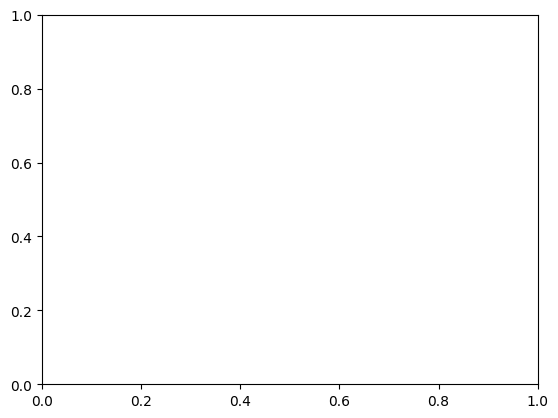

In [7]:
fig, ax = plt.subplots()
for step in range(30000):
    real_data, fake_data, g_loss_value, d_loss_value = train_step()
    if step % 2000 == 0:
        print("G loss: ", g_loss_value.numpy(), " D loss: ", d_loss_value.numpy(), " step: ", step)

        # Sample 5000 values from the Generator and draw the histogram
        ax.hist(fake_data.numpy(), 100)
        ax.hist(real_data.numpy(), 100)
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        textstr = f"step={step}"
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

        axes = plt.gca()
        axes.set_xlim([-1,11])
        axes.set_ylim([0, 60])
        display(plt.gcf())
        plt.gca().clear()

**Hope that you find this notebook helpful. More to come.**

**Please upvote this, to keep me motivate for doing better.**

**Thanks.**